In [ ]:
'''
 Word embedding techniques:
-- Based on CBOW and skip gram in which ANN trained on the text and a side result you get weights as word embeding vector. It includes: Word2vec, GloVe, fastText methods
-- Based on transformer architecture: BERT, GPT
-- Based on LSTM: ELMo

-- Word2vec: trained on words, has problem of OOV while FastText: trained on character n-GRAM, handel OOV nicely, train for your domain (custom)
-- Gensim is a Python library and includes various models for Word2vec embeddings for generating word embeddings (vector representations of words).
-- api.info() is showing all avialible gensim models are listed here: https://github.com/piskvorky/gensim-data
-- Gensim API Models: word2vec-google-news
-- GloVe (Global Vectors for Word Representation) model from standford University https://nlp.stanford.edu/projects/glove/
-- Word2Vec embedding with SpaCy lang Model
'''

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import spacy
import gensim
import gensim.downloader as api 
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

In [9]:
tf.keras.utils.get_file(origin='http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz',
                             cache_dir='.', extract=True)

df=pd.read_json("datasets/reviews_Cell_Phones_and_Accessories_5.json",lines=True)
df.head()

45409631/45409631 ━━━━━━━━━━━━━━━━━━━━ 23s 1us/step


/var/folders/6p/5mzp7fyd4mgchv364j3jy2jr0000gn/T/ipykernel_39711/1148234113.py:1: UserWarning: Could not extract archive.
  tf.keras.utils.get_file(origin='http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz',


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


In [12]:
review_text= df.reviewText.apply(gensim.utils.simple_preprocess) # tokenize the sentense

# Word2Vec gensim model on data

In [50]:
model=gensim.models.Word2Vec(
      window=10,
      min_count=2,
      workers=4,
      vector_size=100    
)
model.build_vocab(review_text, progress_per=500)
model.train(review_text, total_examples=len(review_text), epochs=model.epochs)

(61510015, 83868975)

In [49]:
model.wv.similarity("good","great")
model.wv.most_similar("item")
model.corpus_count
model.wv.vectors.shape
model.wv.vectors[0].shape
model.wv.vector_size
model.wv.get_index('good')
model.wv.key_to_index
model.wv["good"]

array([ 1.8204657 , -2.2501621 ,  2.3243976 ,  1.7318969 , -0.7010403 ,
        0.2839433 ,  2.9624343 ,  1.0002843 ,  0.34557167,  0.88745636,
       -1.886553  ,  2.7619045 , -0.01926234, -2.2938316 , -1.1018366 ,
        2.7109637 ,  1.2904496 ,  2.3829587 ,  2.0005403 , -1.2784208 ,
       -2.6292458 ,  2.4657032 , -0.4176733 ,  1.2948536 , -0.66294783,
        2.244852  , -1.9904323 ,  3.2380457 , -3.4631236 , -0.9400738 ,
        0.09391774, -1.1271873 ,  3.3769734 ,  0.20439222,  0.5587165 ,
       -1.2676477 ,  0.9895228 ,  0.05722122, -2.9530137 , -0.2601852 ,
       -0.9919815 ,  1.7022675 ,  2.0698514 , -0.6259207 , -2.611614  ,
       -1.7562488 ,  3.563456  , -2.2334957 , -3.0962386 ,  0.1181924 ,
        1.8074092 ,  3.0052838 , -3.230116  ,  3.2101202 ,  1.8468437 ,
        0.10067616, -3.0754683 ,  4.687876  , -0.66638994, -5.9529505 ,
        0.01685345,  0.62802   ,  2.377173  , -1.3592235 ,  0.620287  ,
        1.7915851 , -2.2305093 , -2.8235927 , -0.15478559, -6.00

In [59]:
model.wv.get_mean_vector(["embeddings", "model"])
cosine_similarity([model.wv["great"],model.wv["good"]]) # [0][1]

array([[1.0000001, 0.7798734],
       [0.7798734, 1.0000002]], dtype=float32)

In [60]:
model.save("Cell_Phones_review.model")

# News classification with W2V gensim model 

In [3]:
# fake detection news data was taken from: https://www.kaggle.com/code/sharanya02/fake-news-detection/input
df=pd.read_csv("news_articles.csv")
df["label_num"]=df["label"].apply(lambda x: 1 if x=="Real" else 0)
df.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage,label_num
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0,1
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0,1
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0,1
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0,1
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0,1


In [69]:
nlp = spacy.load("en_core_web_lg")
def preprocess_vectorize(text):
    filtered_token=[]
    doc=nlp(text)
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        else:
            filtered_token.append(token.lemma_)
    return(model.wv.get_mean_vector(filtered_token))     

In [72]:
df.dropna(subset=['text'], inplace=True)
df["text_new"]=df["text"].apply(preprocess_vectorize)

In [82]:
x_train,x_test,y_train, y_test=train_test_split(df["text_new"],df["label_num"],stratify=df.label_num,random_state=120)
x_train_2d=np.stack(x_train)
x_test_2d=np.stack(x_test)
x_train_2d.shape

(1537, 100)

In [83]:
model=GradientBoostingClassifier()
model.fit(x_train_2d,y_train)
ypred=model.predict(x_test_2d)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.68      0.86      0.76       323
           1       0.57      0.31      0.40       190

    accuracy                           0.66       513
   macro avg       0.62      0.59      0.58       513
weighted avg       0.64      0.66      0.63       513



<Axes: >

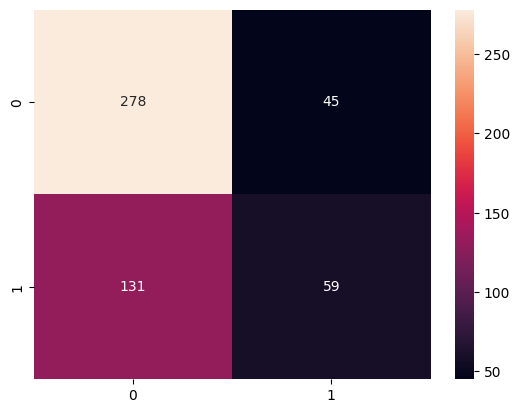

In [87]:
cm=confusion_matrix(y_test, ypred)
sns.heatmap(cm, annot=True, fmt='d')

# Gensim word2vec model of google-news data

In [88]:
wv = api.load('word2vec-google-news-300')  

In [89]:
wv.similarity("good","bad")
wv.most_similar("good", topn=5)
wv.most_similar(positive=["france","berlin"], negative=["paris"], topn=5)
wv.doesnt_match(["dog", "cat", "google", "mouse"])

'google'

In [90]:
wv.get_mean_vector(["dog", "cat"])
cosine_similarity([wv["great"],wv["good"]]) # [0][1]

array([[1.       , 0.729151 ],
       [0.729151 , 1.0000002]], dtype=float32)

In [91]:
nlp = spacy.load("en_core_web_lg")
def preprocess_vectorize(text):
    filtered_token=[]
    doc=nlp(text)
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        else:
            filtered_token.append(token.lemma_)
    return(wv.get_mean_vector(filtered_token))     

In [92]:
df["text_new"]=df["text"].apply(preprocess_vectorize)
x_train,x_test,y_train, y_test=train_test_split(df["text_new"],df["label_num"],stratify=df.label_num,random_state=120)
x_train_2d=np.stack(x_train)
x_test_2d=np.stack(x_test)

In [106]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(x_train_2d,y_train)
ypred=model.predict(x_test_2d)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       323
           1       0.49      0.50      0.50       190

    accuracy                           0.63       513
   macro avg       0.60      0.60      0.60       513
weighted avg       0.63      0.63      0.63       513



/usr/local/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


<Axes: >

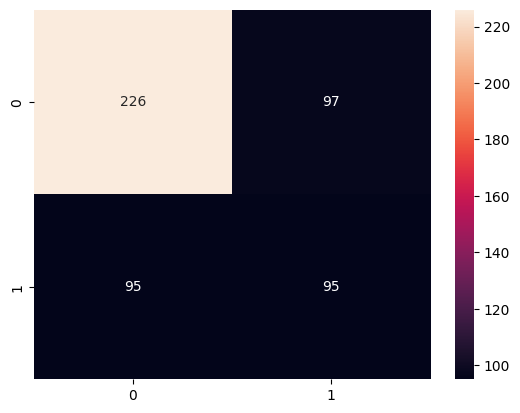

In [107]:
cm=confusion_matrix(y_test, ypred)
sns.heatmap(cm, annot=True, fmt='d')

# Gensim Word2Vec model of GloVe

In [109]:
glv = api.load("glove-twitter-25")

In [110]:
glv.similarity("good","bad")
glv.most_similar("good",topn=5)
glv.doesnt_match("breakfast cereal dinner lunch".split())

'cereal'

In [111]:
nlp = spacy.load("en_core_web_lg")
def preprocess_vectorize(text):
    filtered_token=[]
    doc=nlp(text)
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        else:
            filtered_token.append(token.lemma_)
    return(glv.get_mean_vector(filtered_token))     

In [112]:
df["text_new"]=df["text"].apply(preprocess_vectorize)
x_train,x_test,y_train, y_test=train_test_split(df["text_new"],df["label_num"],stratify=df.label_num,random_state=120)
x_train_2d=np.stack(x_train)
x_test_2d=np.stack(x_test)

In [113]:
model=DecisionTreeClassifier()
model.fit(x_train_2d,y_train)
ypred=model.predict(x_test_2d)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66       323
           1       0.42      0.40      0.41       190

    accuracy                           0.57       513
   macro avg       0.53      0.53      0.53       513
weighted avg       0.57      0.57      0.57       513



<Axes: >

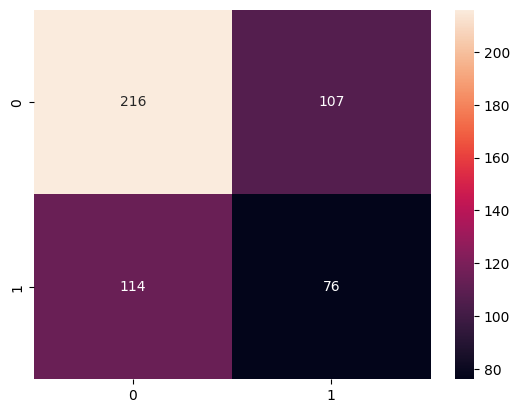

In [114]:
cm=confusion_matrix(y_test, ypred)
sns.heatmap(cm, annot=True, fmt='d')

In [115]:
test_news = [
    "Michigan governor denies misleading U.S. House on Flint water (Reuters) - Michigan Governor Rick Snyder denied Thursday that he had misled a U.S. House of Representatives committee last year over testimony on Flintâ€™s water crisis after lawmakers asked if his testimony had been contradicted by a witness in a court hearing. The House Oversight and Government Reform Committee wrote Snyder earlier Thursday asking him about published reports that one of his aides, Harvey Hollins, testified in a court hearing last week in Michigan that he had notified Snyder of an outbreak of Legionnairesâ€™ disease linked to the Flint water crisis in December 2015, rather than 2016 as Snyder had testified. â€œMy testimony was truthful and I stand by it,â€ Snyder told the committee in a letter, adding that his office has provided tens of thousands of pages of records to the committee and would continue to cooperate fully.  Last week, prosecutors in Michigan said Dr. Eden Wells, the stateâ€™s chief medical executive who already faced lesser charges, would become the sixth current or former official to face involuntary manslaughter charges in connection with the crisis. The charges stem from more than 80 cases of Legionnairesâ€™ disease and at least 12 deaths that were believed to be linked to the water in Flint after the city switched its source from Lake Huron to the Flint River in April 2014. Wells was among six current and former Michigan and Flint officials charged in June. The other five, including Michigan Health and Human Services Director Nick Lyon, were charged at the time with involuntary manslaughter",
    " WATCH: Fox News Host Loses Her Sh*t, Says Investigating Russia For Hacking Our Election Is Unpatriotic This woman is insane.In an incredibly disrespectful rant against President Obama and anyone else who supports investigating Russian interference in our election, Fox News host Jeanine Pirro said that anybody who is against Donald Trump is anti-American. Look, it s time to take sides,  she began.",
    " Sarah Palin Celebrates After White Man Who Pulled Gun On Black Protesters Goes Unpunished (VIDEO) Sarah Palin, one of the nigh-innumerable  deplorables  in Donald Trump s  basket,  almost outdid herself in terms of horribleness on Friday."
]


In [116]:
test_news_process=[preprocess_vectorize(i) for i in test_news]
test_news_process_2d=np.stack(test_news_process)
ypred_test=model.predict(test_news_process_2d)
ypred_test

array([0, 0, 0])

# Word2Vec embedding with SpaCy lang Model

In [4]:
nlp=spacy.load('en_core_web_lg')
doc = nlp("dog cat banana kem")
for token in doc:
    print(f"{token.text}, Vector:{token.has_vector} , OOV:{token.is_oov}")

dog, Vector:True , OOV:False
cat, Vector:True , OOV:False
banana, Vector:True , OOV:False
kem, Vector:False , OOV:True


In [5]:
doc[0].vector.shape

(300,)

In [6]:
cosine_similarity([token.vector for token in doc])

array([[1.0000001 , 0.8220816 , 0.20909055, 0.        ],
       [0.8220816 , 0.9999999 , 0.22358824, 0.        ],
       [0.20909055, 0.22358824, 0.99999994, 0.        ],
       [0.        , 0.        , 0.        , 0.        ]], dtype=float32)

In [7]:
cosine_similarity([nlp.vocab["bad"].vector, nlp.vocab["good"].vector])

array([[0.9999997, 0.739189 ],
       [0.739189 , 0.9999996]], dtype=float32)

In [8]:
df=pd.read_csv("news_articles.csv")
df.dropna(subset=['text'], inplace=True)
df["label_num"]=df["label"].apply(lambda x: 1 if x=="Real" else 0)
df["text_vector"]=df["text"].apply(lambda x: nlp(x).vector)

In [11]:
x_train,x_test,y_train, y_test=train_test_split(df["text_vector"],df["label_num"],stratify=df.label_num,random_state=120)
x_train_2d=np.stack(x_train)
x_test_2d=np.stack(x_test)


scaler=MinMaxScaler()
x_train_scale=scaler.fit_transform(x_train_2d)
x_test_scale=scaler.transform(x_test_2d)

In [14]:
model= MultinomialNB()
model.fit(x_train_scale,y_train)
ypred=model.predict(x_test_scale)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77       323
           1       0.00      0.00      0.00       190

    accuracy                           0.63       513
   macro avg       0.31      0.50      0.39       513
weighted avg       0.40      0.63      0.49       513



/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
model= KNeighborsClassifier(n_neighbors=10)
model.fit(x_train_scale,y_train)
ypred=model.predict(x_test_scale)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.69      0.83      0.75       323
           1       0.55      0.36      0.43       190

    accuracy                           0.65       513
   macro avg       0.62      0.59      0.59       513
weighted avg       0.64      0.65      0.63       513



/usr/local/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


<Axes: >

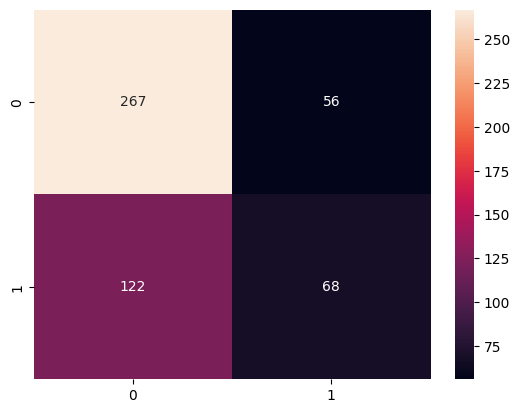

In [16]:
cm=confusion_matrix(y_test, ypred)
sns.heatmap(cm, annot=True, fmt='d')